# Overview 

## Objective

This notebook provides an example of how to train Tensorflow classifiers using the HMEQ dataset

The goal is to predict whether a customer is a BAD (default) borrower, which in this dataset is a binary classification task.

## Assumption

We are working in big data context. 

Then, I'm going to work with HMEQ dataset as it is so large that it would not fit in RAM. 

Then we use the Tensorflow framework to deal with that.

## Imports and setup

In [1]:
#General
import os
import functools
import shutil
import datetime

#Analysis
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Settings
matplotlib.rcParams['figure.figsize'] = (12, 10)

## Define variables

In [2]:
BASE_DIR_PATH = os.getcwd()
DATA_DIR_PATH = os.path.join(BASE_DIR_PATH, '../data')

# Data directories paths
TRAIN_DIR_PATH = os.path.join(DATA_DIR_PATH, 'train')
TEST_DIR_PATH = os.path.join(DATA_DIR_PATH, 'test')
VAL_DIR_PATH = os.path.join(DATA_DIR_PATH, 'val')

# Data file paths
TRAIN_DATA_PATH = os.path.join(TRAIN_DIR_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(TEST_DIR_PATH, 'test.csv')
VAL_DATA_PATH = os.path.join(VAL_DIR_PATH, 'val.csv')

# Model directories
LOG_DIR = os.path.join(BASE_DIR_PATH, '../logs')
MODEL_DIR = os.path.join(BASE_DIR_PATH, '../models')

## Define Helpers

**Notice**: TF adds tf.keras.layers.experimental.preprocessing to deal with preprocessing tasks

TF needs several preprocessing functions in order to perform data manipulation and feature engineering tasks

In [3]:
## Preprocessing data

def _set_categorical_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Set the categorical type as string if neeeded
    :param dataframe: 
    :return: dataframe
    '''
    for column in CATEGORICAL_VARIABLES:
        if (dataframe[column].dtype == 'O'):
            dataframe[column] = dataframe[column].astype('string')
    return dataframe

def _set_categorical_empty(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Change object type for categorical variable to avoid TF issue
    :param dataframe: 
    :return: dataframe
    '''
    for column in CATEGORICAL_VARIABLES:
        if any(dataframe[column].isna()):
            dataframe[column] = dataframe[column].fillna('')
    return dataframe

def _set_numerical_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Set the numerical type as float64 if needed
    :param dataframe:
    :return: dataframe
    '''
    for column in NUMERICAL_VARIABLES:
        if (dataframe[column].dtype == 'int64'):
            dataframe[column] = dataframe[column].astype('float64')
    return dataframe

def _get_impute_parameters_cat(categorical_variables: list) -> dict:
    '''
    For each column in the categorical features, assign default value for missings.
    :param categorical_variables:
    :return: impute_parameters
    '''

    impute_parameters = {}
    for column in categorical_variables:
        impute_parameters[column] = 'Missing'
    return impute_parameters
    
def _impute_missing_categorical(inputs: dict, target) -> dict:
    '''
    Given a tf.data.Dataset, impute missing in categorical variables with default 'missing' value
    :param inputs:
    :param target:
    :return: output, target
    '''
    impute_parameters = _get_impute_parameters_cat(CATEGORICAL_VARIABLES)
    # Since we modify just some features, we need to start by setting `outputs` to a copy of `inputs.
    output = inputs.copy()
    for key, value in impute_parameters.items():
        is_blank = tf.math.equal('', inputs[key])
        tf_other = tf.constant(value, dtype=np.string_)
        output[key] = tf.where(is_blank, tf_other, inputs[key])
    return output, target

def _get_mean_parameter(dataframe: pd.DataFrame, column: str) -> float:
    '''
    Given a DataFrame column, calculate mean
    :param dataframe: 
    :param column: 
    :return: mean
    '''
    mean = dataframe[column].mean()
    return mean

def _get_impute_parameters_num(dataframe: pd.DataFrame, numerical_variables: list) -> dict:
    '''
    Given a DataFrame and its numerical variables, return the associated dictionary of means
    :param dataframe: 
    :param numerical_variables: 
    :return: impute_parameters
    '''

    impute_parameters = {}
    for column in numerical_variables:
        impute_parameters[column] = _get_mean_parameter(dataframe, column)
    return impute_parameters

def _impute_missing_numerical(inputs: dict, target) -> dict:
    '''
    Given a tf.data.Dataset, impute missing in numerical variables with training means
    :param inputs:
    :param target:
    :return: output, target
    '''
    # Get mean parameters for imputing 
    impute_parameters = _get_impute_parameters_num(data_train, NUMERICAL_VARIABLES) 
    # Since we modify just some features, we need to start by setting `outputs` to a copy of `inputs.
    output = inputs.copy()
    for key, value in impute_parameters.items():
        # Check if nan (true, false mask)
        is_miss = tf.math.is_nan(inputs[key])
        # Store mean in a tf.constant
        tf_mean = tf.constant(value, dtype=np.float64)
        # Impute missing
        output[key] = tf.where(is_miss, tf_mean, inputs[key])
    return output, target

def _get_std_parameter(dataframe:pd.DataFrame, column:str) -> float:
    '''
    Given a DataFrame column, calculate std
    :param dataframe:
    :param column:
    :return: std
    '''
    std = dataframe[column].std()
    return std

def _get_normalization_parameters(numerical_variables: list) -> dict:
    '''
    For each numerical variable, calculate mean and std based on training dataframe
    :param numerical_variables: 
    :return: normalize_parameters
    '''
    normalize_parameters = {}
    for column in numerical_variables:
        normalize_parameters[column] = {}
        normalize_parameters[column]['mean'] = _get_mean_parameter(data_train, column)
        normalize_parameters[column]['std'] = _get_std_parameter(data_train, column)
    return normalize_parameters
    
def normalizer(column, mean, std):
    '''
    Given a column, Normalize with calculated mean and std
    :param column: 
    :param mean: 
    :param std: 
    :return: 
    '''
    return (column - mean) / std
            
def check_feature(feature_column):
    '''
    Given a tf.feature_column and an iter, transform a batch of data
    :param feature_column:
    :return: None
    '''
    feature_layer = keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

def calculate_roc(labels, predictions): #sample
    fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr
    
def calculate_correlation_matrix(labels, predictions, p=0.5):
    corrmat = confusion_matrix(labels, predictions > p)
    return corrmat
    
def plot_metrics(name, labels, predictions, p=0.5):
    metrics = ['roc', 'corrmat']
    for n, metric in enumerate(metrics):
        plt.subplot(2,2,n+1)
        if metric == 'corrmat':
            corrmat = calculate_correlation_matrix(labels, predictions, p)
            sns.heatmap(corrmat, annot=True, fmt="d")
            plt.title(name + ' - ' + 'Confusion matrix with p = {:.2f}'.format(p))
            plt.ylabel('Actual label')
            plt.xlabel('Predicted label')
        if metric == 'roc':
            fpr, tpr = calculate_roc(labels=labels, predictions=predictions)
            plt.plot(fpr, tpr)
            plt.title(name + ' - ' + 'ROC curve')
            plt.xlabel('false positive rate')
            plt.ylabel('true positive rate')
            plt.xlim(0,)
            plt.ylim(0,)
            
def print_metrics(corrmat, metrics):
    print('Correlation matrix info')
    print('True Negatives - No default loans that pay', corrmat[0][0])
    print('False Positives - No default loans that dont pay', corrmat[0][1])
    print('False Negatives - Default loans that pay', corrmat[1][0])
    print('True Positives: - Default loans that dont pay', corrmat[1][1])
    print('Total Defauts: ', np.sum(corrmat[1]))
    print()
    print('-'*20)
    print()
    print('Evalutation Metrics')
    for key, value in metrics.items():
        print(key, ':', value)

---

# 1. Data

## Preview data

In [4]:
!head -n 5 ../data/train/train.csv

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,34400,97971.0,145124.0,DebtCon,Other,13.0,0.0,0.0,67.8320416646805,1.0,36.0,40.4027058419691
0,13600,89937.0,110986.0,DebtCon,Sales,14.0,,2.0,146.718742448452,1.0,17.0,33.7471158335903
1,10800,75000.0,87400.0,HomeImp,Other,7.0,1.0,0.0,101.46666666666701,2.0,19.0,
0,14900,87167.0,114219.0,DebtCon,ProfExe,8.0,0.0,0.0,194.113173533089,2.0,36.0,41.3297639035293


## Load Data

In [5]:
data_train = pd.read_csv(TRAIN_DATA_PATH, sep=',')
data_test = pd.read_csv(TEST_DATA_PATH, sep=',')
data_val = pd.read_csv(VAL_DATA_PATH, sep=',')                              

In [6]:
data_train.head(5)                    

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,34400,97971.0,145124.0,DebtCon,Other,13.0,0.0,0.0,67.832042,1.0,36.0,40.402706
1,0,13600,89937.0,110986.0,DebtCon,Sales,14.0,NaN,2.0,146.718742,1.0,17.0,33.747116
2,1,10800,75000.0,87400.0,HomeImp,Other,7.0,1.0,0.0,101.466667,2.0,19.0,NaN
3,0,14900,87167.0,114219.0,DebtCon,ProfExe,8.0,0.0,0.0,194.113174,2.0,36.0,41.329764
4,0,7200,98691.0,115750.0,HomeImp,Office,22.0,0.0,0.0,118.000142,0.0,11.0,37.720359


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4827 entries, 0 to 4826
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      4827 non-null   int64  
 1   LOAN     4827 non-null   int64  
 2   MORTDUE  4405 non-null   float64
 3   VALUE    4738 non-null   float64
 4   REASON   4618 non-null   object 
 5   JOB      4601 non-null   object 
 6   YOJ      4419 non-null   float64
 7   DEROG    4262 non-null   float64
 8   DELINQ   4362 non-null   float64
 9   CLAGE    4578 non-null   float64
 10  NINQ     4421 non-null   float64
 11  CLNO     4651 non-null   float64
 12  DEBTINC  3804 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 490.4+ KB


In [8]:
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BAD,4827.0,0.198674,0.399043,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,4827.0,18617.112078,11231.974061,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,4405.0,73796.339364,43741.460123,2063.000000,46884.000000,65206.000000,91491.000000,399412.000000
VALUE,4738.0,101633.021895,56564.609914,8000.000000,66260.250000,89407.500000,119732.500000,855909.000000
YOJ,4419.0,8.957377,7.604500,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,4262.0,0.244486,0.823733,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,4362.0,0.446813,1.138853,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,4578.0,179.902913,86.744368,0.000000,114.858318,173.497696,231.876088,1168.233561
NINQ,4421.0,1.199276,1.745287,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,4651.0,21.322081,10.111162,0.000000,15.000000,20.000000,26.000000,71.000000


In [9]:
print(data_train['BAD'].value_counts()/data_train.shape[0])

0    0.801326
1    0.198674
Name: BAD, dtype: float64


**Comment**: We notice that several variables (numerical and categorical) have missing values. The dataset is unbalanced.

---

# 2. Data Ingestion

In this section, I define the input_fn pipeline.

## Premises

Based on documentation, when you import data in Tensorflow you need two elements:

**1. input_fn**: specifies how data is converted to a tf.data.Dataset that feeds the input pipeline.

**2. feature column**: a construct that indicates a feature's data type.

In our case: 

- We notice that variables have missing. Then we need to impute them. 

- Also we need to normalize data. 

And because we want to use Tensorflow framework, we can implement data preprocessing and transformation operations in the TensorFlow model itself. In this way, **it becomes an integral part of the model when the model is exported and deployed for predictions.**

TensorFlow transformations can be accomplished in one of the following ways:

1. Extending your base feature_columns (using crossed_column, embedding_column, bucketized_column, and so on).

2. Implementing all of the instance-level transformation logic in a function that you call in all three input functions: train_input_fn, eval_input_fn, and serving_input_fn.

3. If you are creating custom estimators, putting the code in the model_fn function.

Then, we have two approaches to inputs:

**1. Inside the input_fn**

**2. While creating feature_column**

Personally I prefer 

1. Preprocess data in the input_fn 

2. Do feature engineering while creating feature_column.

About **the Data preprocessing strategy of impute missings**, 

- numerical variables: impute with mean

- categorical variables: create 'other' class

About **Feature Engineering**, 

- define normalizer_fn to normalize numerical variables

## Define input_fn to create tf.data.Dataset

As quick start model we choose Estimator. And It expects their inputs to be formatted as a pair of objects:

1. A dictionary in which the keys are feature names and the values are Tensors (or SparseTensors) containing the corresponding feature data
2. A Tensor containing one or more labels

In [10]:
TARGET = ['BAD']
CATEGORICAL_VARIABLES = ['REASON', 'JOB']
NUMERICAL_VARIABLES = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

In [11]:
def get_dataset(dataframe: pd.DataFrame, target: str, num_epochs=2, mode='eval', batch_size=5):
    '''
    Return input_fn function for TF data ingestion pipeline
    :param dataframe: 
    :param target: 
    :param num_epochs: 
    :param mode: 
    :param batch_size: 
    :return: input_fn()
    '''
    def input_fn():
        '''
        Extract data from pd.DataFrame, Impute and enhance data, Load data in parallel
        :return: 
        '''

        # Extract
        df = _set_categorical_type(dataframe)
        df = _set_categorical_empty(df)
        df = _set_numerical_type(df)
        predictors = dict(df)
        label = predictors.pop(target)
        dataset = tf.data.Dataset.from_tensor_slices((predictors, label))

        # Transform
        dataset = dataset.map(_impute_missing_categorical)
        dataset = dataset.map(_impute_missing_numerical)

        if mode == 'train':
            dataset = dataset.repeat(num_epochs)  # repeat the original dataset 3 times 
            dataset = dataset.shuffle(buffer_size=1000, seed=8)  # shuffle with a buffer of 1000 element

        dataset = dataset.batch(5, drop_remainder=False)  # small batch size to print result

        # Load
        dataset = dataset.prefetch(1)  # It optimize training parallelizing batch loading over CPU and GPU
        
        return dataset

    return input_fn

In [12]:
# Load small batch to get example and go on with preprocessing
train_input_fn = get_dataset(data_train, 'BAD', mode='train', batch_size=5)
test_input_fn = get_dataset(data_test, 'BAD', batch_size=5)
eval_input_fn = get_dataset(data_val, 'BAD', batch_size=5)

In [13]:
# Print a batch example
for feature_batch, label_batch in train_input_fn().take(1):
    print('Feature keys:', list(feature_batch.keys()))
    print('A batch of REASON:', feature_batch['REASON'].numpy())
    print('A batch of Labels:', label_batch.numpy())

Feature keys: ['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
A batch of REASON: [b'DebtCon' b'DebtCon' b'DebtCon' b'DebtCon' b'DebtCon']
A batch of Labels: [0 0 0 0 0]


---

# 3. Feature Engineering (Preprocessing)

In this section, I implemented feature engineering as Tensorflow Framework requires.

## Define features and configures feature_columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. 

In our case, we have:

1. **Categorical Data**: 'REASON', 'JOB'

2. **Numerical Data**: 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**.

Feature columns store only a description of the feature data; they do not contain the feature data itself.

**Notice**: So far we mentioned that we can extend their functionalies in order to apply prepocessing transformations. That's what we are going to do: 

1. Normalize Numerical variables with normalizer_fn

2. OneHot encoding with tf.feature_column.categorical_column_with_vocabulary_list

In [14]:
def get_features(num_features: list, cat_features: list, labels_dict: dict) -> list:
    '''
    Return a list of tf feature columns
    :param num_features: 
    :param cat_features: 
    :param labels_dict: 
    :return: feature_columns
    '''
    # Create an empty list for feature
    feature_columns = []

    # Get numerical features
    normalize_parameters = _get_normalization_parameters(num_features)
    for col_name in num_features:
        mean = normalize_parameters[col_name]['mean']
        std = normalize_parameters[col_name]['std']
        normalizer_fn = functools.partial(normalizer, mean=mean, std=std)
        num_feature = tf.feature_column.numeric_column(col_name, dtype=tf.float32, normalizer_fn=normalizer_fn)
        feature_columns.append(num_feature)

    # Get categorical features
    for col_name in cat_features:
        cat_feature = tf.feature_column.categorical_column_with_vocabulary_list(col_name, labels_dict[col_name])
        indicator_column = tf.feature_column.indicator_column(cat_feature)
        feature_columns.append(indicator_column)

    return feature_columns

In [15]:
# Create the tf.data.dataset and an iterator to check transformations
train_dataset = train_input_fn()            
example_batch = next(iter(train_dataset))[0]

labels_dict= {'REASON': ['DebtCon', 'HomeImp', 'Missing'],
              'JOB' : ['Other', 'Sales', 'ProfExe', 'Office', 'Mgr', 'Self', 'Missing']}
feature_columns = get_features(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, labels_dict)

In [16]:
feature_columns[::3]

[NumericColumn(key='LOAN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f75debb5670>, mean=18617.112077895174, std=11231.974060952927)),
 NumericColumn(key='YOJ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f75debb5670>, mean=8.957377234668478, std=7.60449983387714)),
 NumericColumn(key='CLAGE', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f75debb5670>, mean=179.90291295790095, std=86.74436793774018)),
 NumericColumn(key='DEBTINC', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalizer at 0x7f75debb5670>, mean=33.76880402048964, std=8.806655753842648))]

In [17]:
check_feature(feature_columns[0])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 0.80866367]
 [-0.97196734]
 [ 0.03408917]
 [ 1.2805308 ]
 [-0.3309402 ]]


In [18]:
check_feature(feature_columns[-1])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


---

# 4. Model Experiments (training)

In this section, I train different models to get the Champion.

In particular, 

    a. Model A: pre-made Estimator
    b. Model B: custom Estimator (Keras model)
    
In this way, I can compare both model based on TF API and model based on my business knowledge.
    
**Notice**: Dataset is heavly inbalanced. Because it is a plain vanilla example I'm not going to deal with that.

## Model A: pre-made Estimator

### Build the pre-made Estimator

In [19]:
def build_estimator(feature_columns, learning_rate=0.01):
    """
     Build an estimator.
    """
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float32')
    
    runconfig = tf.estimator.RunConfig(tf_random_seed=8)
    
    linear_classifier_base = tf.estimator.LinearClassifier(
    model_dir=LOG_DIR, 
    feature_columns=feature_columns,
    n_classes=2,
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    
    return linear_classifier_base

In [20]:
estimator = build_estimator(feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/jovyan/work/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train pre-made Estimator

In [21]:
def train_and_evaluate():
    '''Remember to parametrize'''
    # Get dataset
    train_input_fn = get_dataset(data_train, 'BAD', batch_size=500, mode='train')
    test_input_fn = get_dataset(data_test, 'BAD', batch_size=500)
    # Get Features
    feature_columns = get_features(NUMERICAL_VARIABLES, CATEGORICAL_VARIABLES, labels_dict)
    #Clean all
    shutil.rmtree(LOG_DIR, ignore_errors = True) 
    # Get estimator
    estimator = build_estimator(feature_columns)
    # Train the estimator
    estimator_train = estimator.train(input_fn=train_input_fn, steps=10)
    # Evaluate 
    metrics = estimator_train.evaluate(input_fn=test_input_fn, steps=10)
    return estimator_train, metrics

In [22]:
model, metrics = train_and_evaluate()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/jovyan/work/notebooks/../logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically

### Evaluate pre-made Estimator

In [23]:
predictions_dictionary = list(model.predict(test_input_fn))
predictions = pd.Series([pred['class_ids'] for pred in predictions_dictionary])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/jovyan/work/notebooks/../logs/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


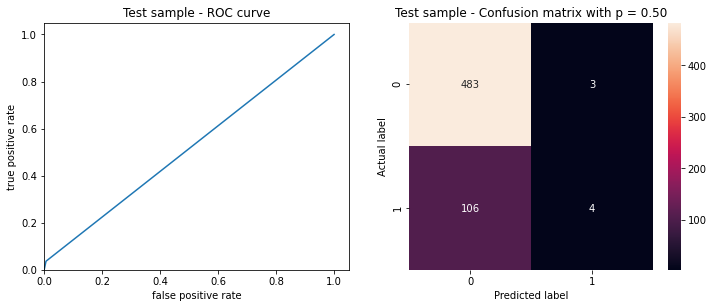

In [25]:
test_labels = data_test['BAD']
plot_metrics("Test sample", test_labels, predictions, p=0.5)

In [26]:
print_metrics(calculate_correlation_matrix(test_labels, predictions), metrics)

Correlation matrix info
True Negatives:  483
False Positives:  3
False Negatives:  106
True Positives:  4
Total Defauts:  110

--------------------

Evalutation Metrics
accuracy : 0.86
accuracy_baseline : 0.86
auc : 0.4501661
auc_precision_recall : 0.19473608
average_loss : 0.665033
label/mean : 0.14
loss : 0.66503286
precision : 0.0
prediction/mean : 0.47950876
recall : 0.0
global_step : 10


## Model B: Custom Estimator (Keras Model using Sequential API)

To train a Custom Keras Model, we have:

1. Initiate the model (create the architecture)
2. Compile the model defining the learning process (provide optimizer, loss function and metrics)

Then, you can train it.

For simplicity, we create a builder to cover step 1 and 2 as we did for Estimator.

### Build the Model

In [ ]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall')  
]

In [ ]:
model = keras.Sequential()
model.add(DenseFeatures(feature_columns=feature_columns))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

### Train the Model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 500

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)

In [ ]:
%time
train_input_fn = get_dataset(data_train, 'BAD', batch_size=500, mode='train')
test_input_fn = get_dataset(data_test, 'BAD', batch_size=500)

history = model.fit(x=train_input_fn(),
                    steps_per_epoch=EPOCHS,
                    epochs=50,
                    validation_data=test_input_fn())

In [ ]:
model.summary()

In [ ]:
LOSS_COLS = ['loss', 'val_loss']

pd.DataFrame(history.history)[LOSS_COLS].plot()

## Save your model

In [ ]:
# https://guillaumegenthial.github.io/serving-tensorflow-estimator.html
# shutil.rmtree(MODEL_DIR, ignore_errors=True)
VERSION = 1
DATE = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
ID = "_".join([str(DATE), str(VERSION)])
EXPORT_PATH = os.path.join(MODEL_DIR, ID)

In [ ]:
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(tf.feature_column.make_parse_example_spec(feature_columns))

In [ ]:
estimator.export_saved_model(EXPORT_PATH, serving_input_fn)

In [ ]:
%%bash
export DIR=/home/jovyan/work/notebooks/../models/20200926094312_1/1601113396
saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir $DIR

## Test it with Docker via Restful API

I could do that using Python Docker client. 

Check my project here: https://github.com/IvanNardini/modelops-aws-web-endpoint-hosted/blob/master/notebooks/02_engineering.ipynb

In that case, go on terminal and run the following commands.

In my case...

```bash
docker pull tensorflow/serving
EXPORT_BASE_DIR=/home/ubuntu/modelops-sas-tensorflow-workflow-manager-openshift/models/20200926093215_1/
docker run -t --rm --name tf -p 8501:8501 -v "$EXPORT_BASE_DIR:/models/model" tensorflow/serving
SERVER=$(hostname -I | cut -d ' ' -f1)
curl -d '{"examples":[{"LOAN": 34400.0, "MORTDUE": 97971.0, "VALUE": 145124.0, "YOJ": 13.0, "DEROG": 0.0, "DELINQ": 0.0, "CLAGE": 67.832, "NINQ": 1.0, "CLNO": 36.0, "DEBTINC": 40.402, "REASON": "DebtCon", "JOB": "Other"}]}' -X POST http://$SERVER:8501/v1/models/model:classify
```